In [1]:
import numpy as np
import librosa
import librosa.display
import librosa.feature
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import IPython.display as ipd
import glob
import os
import pandas as pd
import scipy
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import jams
import matplotlib.lines as mlines
import pickle

Using TensorFlow backend.


<font size = 4> <b> Defining functions

In [2]:
def onset_clip(x, x_split, sr, pre = 0.1, post = 0.2):
    """
    Returns 0.3s onset_clip (0.1s before and 0.2s after the detected onset) after detecting onset based on librosa 
    and correlation between x and x_split
    """
    corr = scipy.signal.correlate(x, x_split, mode='full')
    corr_max = np.argmax(corr)-len(x_split)
    onset_frames = librosa.onset.onset_detect(x, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
    onset_times = librosa.frames_to_time(onset_frames, sr)
    onset_samples = onset_times * int(sr)
    onset_arg = np.argmin(np.abs(onset_samples-corr_max))
    onset_num = onset_samples[onset_arg]
    onset_clip = x[int(onset_num) - int(pre * sr): int(onset_num) + int(post * sr)]
    return onset_clip, onset_num

def wav_path_gen(files):
    """
    Generates path of corresponding wav_split_file
    Input: Subfolder of the form 'Dataset/wav/1/hamming_whole_step/filename.wav'
    """  
    wav_file = []
    for file in files:
        test = file.split('/')
        wav_name = test[4].split('.')[0].split('_')
        path = test[0] + '/wav/' + test[2] + '/' + test[3] + '/'
        wav_path = []
        for i in np.arange(len(wav_name)-1):   
            path = path + wav_name[i] +'_'
        wav_file.append(path[:-1] + '.wav')
    return wav_file

def wav_split_onset_num(files):
    path = []
    for file in files:
        path_test = file.split('/')[0] + '/wav_split/' + file.split('/')[2] + '/' + file.split('/')[3] + '/' + file.split('/')[4]
        path.append(path_test)
    return path

In [3]:
# Functions for DF creation

def gen_filename(wav_split_files):
    index = []
    filenames = []
    for fp in wav_split_files:
        filename = fp.split('/')[-1]
        index.append(fp)
        filenames.append(filename)
    return index, filenames

def read_audio(files, resample_rate = 44100):
    audio = []
    for fp in files:
        x, sr = librosa.load(fp, sr = resample_rate)
        audio.append(x)
    return audio, sr

def gen_style(audio_data):
    """
    Audio data = Dataframe
    """    
    style = []
    for i in np.arange(len(audio_data)):
        test = audio_data.filename[i].split('_')
        test = test[0]
        style.append(test)
        
    return style

def gen_tone(files):
    
    tone = []
    for file in files:
        tone_file = file.split('/')[2]
        tone.append(tone_file)
        
    return tone

def gen_onsetnum(filenames):
    onset_nums = []
    for name in filenames:
        onset_num = name.split('_')[-1].split('.')[0]
        onset_nums.append(onset_num)
    return onset_nums

In [4]:
def read_pkl(filename):
    pkl_file = open(filename, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

def save_pkl(data, output_filename):   
    output = open(output_filename, 'wb')
    pickle.dump(data, output)
    output.close()

<font size = 4> <b> Onset Detection on dataset

In [5]:
# Tracking folder names
folders = os.listdir('Dataset/wav/1')
folders.remove('.DS_Store')
print (folders)
print (len(folders))

['hamming_whole_step', 'slide_whole_step_up', 'slide_whole_step_down', 'trill', 'normal_whole_step_up', 'bending_up_whole', 'mute', 'pulling_whole_step', 'bending_up_down_whole', 'hamming_half_step', 'slide_half_step_up', 'pulling_half_step', 'normal_half_step_down', 'slide_half_step_down', 'normal_half_step_up', 'normal', 'bending_up_down_half', 'bending_up_half', 'normal_whole_step_down']
19


<font size = 4> Reading all wav_split files from wav_split_v1 folder and finding corresponding wav files

In [6]:
files = glob.glob("Dataset/wav_split_final_v1/**/**/*.wav")
resample_rate = 22050
print (len(files))
# print (files)

3322


In [7]:
wav_files = wav_path_gen(files)
print (len(wav_files))
# print (wav_files)

3322


In [8]:
wav_split_files = wav_split_onset_num(files)
print (len(wav_split_files))
# print (wav_split_files)

3322


<font size = 4> Generating clips

In [9]:
index, filenames = gen_filename(wav_split_files)

In [10]:
filenames

['hamming_whole_step_19_1.wav',
 'hamming_whole_step_24_1.wav',
 'hamming_whole_step_8_1.wav',
 'hamming_whole_step_26_1.wav',
 'hamming_whole_step_22_1.wav',
 'hamming_whole_step_39_1.wav',
 'hamming_whole_step_20_1.wav',
 'hamming_whole_step_9_1.wav',
 'hamming_whole_step_27_1.wav',
 'hamming_whole_step_18_1.wav',
 'hamming_whole_step_38_1.wav',
 'hamming_whole_step_21_1.wav',
 'hamming_whole_step_23_1.wav',
 'hamming_whole_step_36_1.wav',
 'hamming_whole_step_1_1.wav',
 'hamming_whole_step_12_1.wav',
 'hamming_whole_step_10_1.wav',
 'hamming_whole_step_3_1.wav',
 'hamming_whole_step_34_1.wav',
 'hamming_whole_step_30_1.wav',
 'hamming_whole_step_29_1.wav',
 'hamming_whole_step_16_1.wav',
 'hamming_whole_step_32_1.wav',
 'hamming_whole_step_5_1.wav',
 'hamming_whole_step_11_1.wav',
 'hamming_whole_step_35_1.wav',
 'hamming_whole_step_2_1.wav',
 'hamming_whole_step_37_1.wav',
 'hamming_whole_step_13_1.wav',
 'hamming_whole_step_17_1.wav',
 'hamming_whole_step_4_1.wav',
 'hamming_whole

In [12]:
wav_audio, sr = read_audio(wav_files[:10], resample_rate = resample_rate)

In [13]:
sr

22050

In [14]:
wav_split_audio, sr = read_audio(wav_split_files[:10], resample_rate = resample_rate)
print (sr)

22050


In [15]:
print (len(wav_audio))
print (len(wav_audio[0]))
print (len(wav_split_audio))
print (len(wav_split_audio[0]))

10
88201
10
6616


In [83]:
# Detecting onsets using librosa and picking the ones closest to the wav split files
all_clips = []
all_onset_samples = []
for audio in np.arange(len(wav_audio)):
    x = wav_audio[audio]
    x_split = wav_split_audio[audio]
    clip, onset_sample = onset_clip(x, x_split, sr)
    all_clips.append(clip)
    all_onset_samples.append(onset_sample)

In [90]:
print (len(all_clips))
print (len(all_clips[0]))
print (len(all_onset_samples))

3322
6615
3322


In [85]:
min(all_onset_samples)

3584.0

In [86]:
# Generate onset number (from a 4s file in case there are multiple onsets)
onset_nums = gen_onsetnum(filenames)
print (len(onset_nums))

3322


<font size = 4> <b> Pick quality onsets

In [94]:
"""
Considering all clips with total length = 0.3s (Removing the shorter ones due to their positioning - 
either at extreme beginning or extreme end of the 4.0s file)
"""

all_clips_clean = []
filenames_clean = []
len_all_clips_clean = []
i = -1
for clip in all_clips:
    i += 1
    if len(clip) == len(all_clips[0]):
        all_clips_clean.append(clip)
        name = index[i].split('/')[-1]
        filenames_clean.append(name)
        len_all_clips_clean.append(len(clip))

all_clips_clean = np.array(all_clips_clean)
filenames_clean = np.array(filenames_clean)
len_all_clips_clean = np.array(len_all_clips_clean)

In [95]:
print (len(all_clips_clean))
print (len(filenames_clean))
print (min(len_all_clips_clean))
print (max(len_all_clips_clean))

3320
3320
6615
6615


<font size = 4> <b> Computing Spectograms

In [120]:
# Parameters
n_fft = 4096
w = np.hamming(n_fft)
hop_length = int(0.01 * sr)

In [121]:
all_clips_clean.shape

(3320, 6615)

In [122]:
# STFT for all samples
"""
TAKE LOG OF STFT
"""
X = []
for clip in all_clips_clean:
    STFT = abs(librosa.stft(clip, n_fft=n_fft, hop_length=hop_length, window = w))
    X.append(STFT)
X = np.array(X)

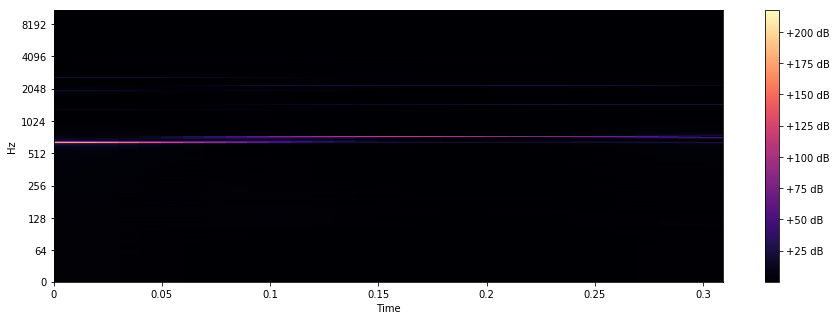

In [123]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(abs(X[3]), sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [124]:
X.shape

(3320, 2049, 31)

In [125]:
filenames_clean.shape

(3320,)

In [126]:
style = []
for file in filenames_clean:
    style_file = file.split('_')[0]
    style.append(style_file)
Y = np.array(style)

In [127]:
# Changing Y to encoded values

from sklearn.preprocessing import LabelEncoder

sle = LabelEncoder()
style_labels = sle.fit_transform(Y)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y = style_labels

In [128]:
"""Using dataframe to store values"""

# # Defining a test_train_split function
# dataset = []
# for spect in np.arange(len(X)):
#     data_file = list(X[spect])
#     data_file.append(Y[spect])
#     dataset.append(data_file)

# dataset = np.array(dataset)

# df = pd.DataFrame(dataset)
# df = df.set_index(filenames_clean)

# column_names = np.arange(dataset.shape[1]-1)
# column_names = np.append(column_names, 'style')
# df.columns = column_names

# df['styleLabel'] = style_labels
# df = df.drop(['style'], axis = 1)
# df.head()

'Using dataframe to store values'

In [129]:
style_mappings

{0: 'bending',
 1: 'hamming',
 2: 'mute',
 3: 'normal',
 4: 'pulling',
 5: 'slide',
 6: 'trill'}

In [130]:
# # Defining a test_train_split function

print (X.shape)
print (Y.shape)

(3320, 2049, 31)
(3320,)


In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [132]:
X_train.shape

(2324, 2049, 31)

In [133]:
y_train.shape

(2324,)

In [134]:
sr_data = sr/1000
sr_data

22.05

In [135]:
path = 'Exp5/Data/{}KHz/abs/{}/'.format(sr_data, n_fft)
path

'Exp5/Data/22.05KHz/abs/4096/'

In [136]:
save_pkl(X_train, path + 'X_train.pkl')

In [137]:
save_pkl(X_test, path + 'X_test.pkl')

In [138]:
save_pkl(y_train, path + 'Y_train.pkl')
save_pkl(y_test, path + 'Y_test.pkl')